# Data Cleaning Exercise

Data Scientists and Analysts are often tasked to clean and analyze datasets. We are working with an external research firm who specializes in the application of artificial intelligence to forecasting prices of financial instruments. This firm has developed a proprietary system, called “4sight”, to forecast prices of certain instruments. 

To demonstrate the effectiveness of their forecasting system, the vendor has sent us attached sample dataset. The dataset includes signal values generated by the 4sight system as well as historical prices for a well-known broad market ETF. 

A Portfolio Manager has asked you to:

1)	Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

2)	Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

3)	(Extra credit) Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

Please budget at least one hour for completing this exercise. Please include all the intermediate steps when sending your solution to this exercise back to us.


---

Tools and methods used in this analysis are based on the setting of this time-limited one-time exercise. Some analyses are based on subjective observation and intuitive judgment, which can be replaced by metrics and rules when automation is required.  

# 1. Quality Check, Errors, and Correction
Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

In [ ]:
# !pip install pandas_market_calendars
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_market_calendars as mcal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_excel('/content/Sample Dataset.xlsx')
df.head()

,Date,Signal,Open,High,Low,Close,Adj Close
0,2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
1,2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2,2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
3,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
4,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


In [ ]:
df.iloc[5:10]

,Date,Signal,Open,High,Low,Close,Adj Close
5,2015-11-27,12.879819,119.269997,119.900002,118.879997,119.620003,111.602997
6,2015-11-30,13.184791,120.019997,120.070000,119.050003,119.099998,111.117851
7,2015-12-01,12.922631,119.610001,119.910004,118.900002,119.889999,111.854897
8,2015-12-02,13.118076,119.730003,120.040001,118.449997,118.599998,110.651367
9,2015-12-03,12.916540,118.930000,119.449997,116.139999,116.599998,108.785408


In [ ]:
# columns, missing values, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB


In [ ]:
# statistical summary for numeric columns
df.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


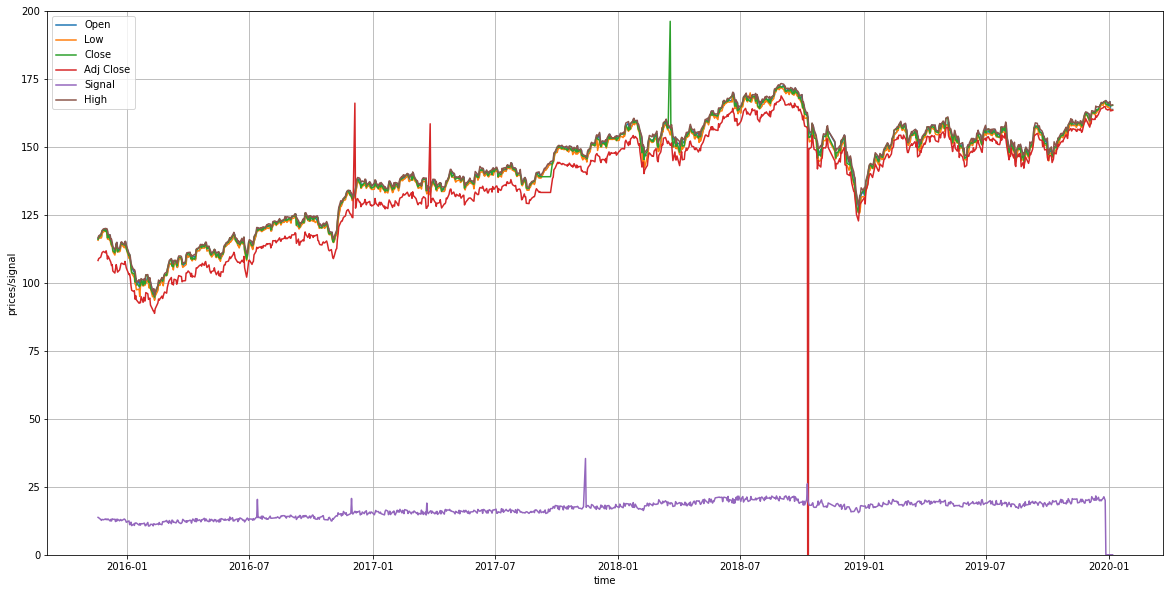

In [ ]:
# a plot to identify abnormal values
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df['Date'],df['Open'], label = 'Open')
ax.plot(df['Date'],df['Low'], label = 'Low')
ax.plot(df['Date'],df['Close'], label = 'Close')
ax.plot(df['Date'],df['Adj Close'], label = 'Adj Close')
ax.plot(df['Date'],df['Signal'], label = 'Signal')
ax.plot(df['Date'],df['High'], label = 'High')
ax.set_xlabel('time')
ax.set_ylabel('prices/signal')
ax.set_ylim(0,200)
ax.grid(True)
ax.legend()

Some basic analysis above shows that:
- The table has 1038 records in total and no missing values
- `Close` and `Adj Close` have abnormal high values
- `Adj Close` and `Signal` have abnormal low values
- The plot shows that `Close` and `Adj Close` have different patterns compared to other prices somewhere between 2017-07 and 2018-01

## 1.1 Data Quality Check


### A. Duplicated records or problematic trading days

In [ ]:
# check duplicates
print(str(df.Date.duplicated().sum()) + ' duplicated date(s)')

0 duplicated date(s)


In [ ]:
## identify problematic trading days
nyse = mcal.get_calendar('NYSE')
tradingD = nyse.schedule(start_date=min(df['Date']), end_date=max(df['Date']))
not_trading_day = [x for x in list(df['Date']) + list(tradingD.index) if x in list(df['Date']) and x not in tradingD.index]
missing_trading_day = [x for x in list(df['Date']) + list(tradingD.index) if x not in list(df['Date']) and x in tradingD.index]
print(str(len(not_trading_day)) + ' non-trading days found')
print(str(len(missing_trading_day)) + ' missing trading days found')
# label problematic trading days
df_ntd = pd.DataFrame({'Date':not_trading_day, 'ErrorCode': [1]*len(not_trading_day)}) # ErrorCode 1, non-trading day
df_mtd = pd.DataFrame({'Date':missing_trading_day, 'ErrorCode': [2]*len(missing_trading_day)}) # ErrorCode 2, missing trading day
df = pd.merge(df, df_ntd, how = 'outer')
df['ErrorCode'] = df.ErrorCode.fillna(0).astype(int)
df[df.ErrorCode > 0]

5 non-trading days found
5 missing trading days found


,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode
407,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998,1
629,2018-05-19,20.448445,162.369995,163.240005,162.360001,162.940002,157.493622,1
630,2018-05-20,19.483907,163.259995,163.330002,161.630005,161.759995,156.352997,1
655,2018-06-23,18.995502,167.240005,167.369995,164.139999,165.080002,159.562042,1
656,2018-06-24,20.274163,165.229996,166.660004,164.850006,166.039993,160.489944,1


### B. Abnormal Prices

**negative values, unresonable prices**

In [ ]:
## negative values, unresonable prices
for i in range(len(df.index)):
  # ErrorCode 20, unresonable price
  # 'Low' is not the lowest price
  if (df.loc[i,'Low'] > df.loc[i,'High']) or (df.loc[i,'Low'] > df.loc[i,'Open']) or (df.loc[i,'Low'] > df.loc[i,'Close']):
    df.loc[i,'ErrorCode'] += 20
  # 'High' is not the highest price
  if (df.loc[i,'High'] < df.loc[i,'Close']) or (df.loc[i,'High'] < df.loc[i,'Open']):
    df.loc[i,'ErrorCode'] += 20
  # ErrorCode +10, negative price
  if min(df.loc[i,'Open':'Adj Close']) < 0:
    df.loc[i,'ErrorCode'] += 10
df[df.ErrorCode > 9].head()

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode
407,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998,21
431,2017-08-07,16.298805,140.440002,140.350000,139.710007,140.440002,134.595871,20
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198,20
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198,20
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198,20


**adjusted close price**

In [ ]:
## adjusted close price
df['diff_close'] = df['Close'] - df['Adj Close']
np.histogram(df['diff_close'],20)

(array([   2,    0, 1034,    0,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1]),
 array([-33.025085 , -15.9319385,   1.161208 ,  18.2543545,  35.347501 ,
         52.4406475,  69.533794 ,  86.6269405, 103.720087 , 120.8132335,
        137.90638  , 154.9995265, 172.092673 , 189.1858195, 206.278966 ,
        223.3721125, 240.465259 , 257.5584055, 274.651552 , 291.7446985,
        308.837845 ]))

The frequency distribution shows that around 4 outliers exists.

In [ ]:
df['diff_close'] = abs(df['diff_close'])
df.sort_values(['diff_close'], ascending = False).head(10)

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
732,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847,10,308.837845
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221,20,45.571778
262,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079,0,33.025085
338,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637,0,23.837632
7,2015-12-01,12.922631,119.610001,119.910004,118.900002,119.889999,111.854897,0,8.035102
5,2015-11-27,12.879819,119.269997,119.900002,118.879997,119.620003,111.602997,0,8.017006
4,2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159,0,7.986839
6,2015-11-30,13.184791,120.019997,120.070000,119.050003,119.099998,111.117851,0,7.982147
8,2015-12-02,13.118076,119.730003,120.040001,118.449997,118.599998,110.651367,0,7.948631
3,2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837,0,7.925163


In [ ]:
## ErrorCode 100, abnormal 'Adj Close'
for i in df[df.diff_close > 10].index:
  df.loc[i,'ErrorCode'] += 100
df[df.ErrorCode > 99]

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
262,2016-12-05,16.011011,131.970001,133.330002,131.889999,133.149994,166.175079,100,33.025085
338,2017-03-27,16.032241,132.759995,135.070007,132.399994,134.740005,158.577637,100,23.837632
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221,120,45.571778
732,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847,110,308.837845


**abnormal prices somewhere between 2017-07 and 2018-01**

In [ ]:
df[df['Date'].between('2017-09-01','2017-10-01')]

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
450,2017-09-01,16.478500,139.979996,140.630005,139.729996,140.520004,134.672531,0,5.847473
451,2017-09-05,15.358602,140.630005,140.889999,138.580002,139.169998,133.378693,0,5.791305
452,2017-09-06,16.318515,139.740005,140.000000,139.080002,139.460007,133.656616,0,5.803391
453,2017-09-07,16.478500,139.589996,139.690002,138.589996,139.110001,133.321198,0,5.788803
454,2017-09-08,15.518587,138.929993,139.770004,138.619995,139.110001,133.321198,0,5.788803
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198,20,5.788803
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198,20,5.788803
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198,20,5.788803
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198,20,5.788803
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198,20,5.788803


It's clear that `Close` and `Adj Close` between 2017-09-07 and 2017-09-22 are invalid due to mistakes in data collection.

In [ ]:
## ErrorCode 40
for i in df[df['Date'].between('2017-09-07','2017-09-22')].index:
  df.loc[i,'ErrorCode'] = 200

### C. Abnormal Signal Values

In [ ]:
np.histogram(df['Signal'],20)

(array([  6,   0,   0,   0,   0,   2,  62, 158, 156, 176, 287, 168,  21,
          0,   1,   0,   0,   0,   0,   1]),
 array([ 0.        ,  1.77170735,  3.5434147 ,  5.31512205,  7.0868294 ,
         8.85853675, 10.6302441 , 12.40195145, 14.1736588 , 15.94536615,
        17.7170735 , 19.48878085, 21.2604882 , 23.03219556, 24.80390291,
        26.57561026, 28.34731761, 30.11902496, 31.89073231, 33.66243966,
        35.43414701]))

Based on the frequency distribution and the plot above, there are near 5 outliers and 6 missing values(0). It's easy to find them by comparing each value with the one before.

In [ ]:
print(df['Signal'].diff(1).sort_values(ascending = False).head(10))
df[df.index.isin(df['Signal'].diff(1).sort_values(ascending = False).head(5).index)]

500    17.805763
161     6.549559
731     5.757141
259     5.406943
335     4.398665
730     2.013456
780     1.915771
985     1.915043
903     1.787952
304     1.769263
Name: Signal, dtype: float64


,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
161,2016-07-13,20.395083,120.330002,120.389999,118.949997,119.250000,112.691780,0,6.558220
259,2016-11-30,20.738650,132.919998,133.089996,131.500000,131.610001,124.715752,0,6.894249
335,2017-03-22,19.029316,133.710007,134.309998,132.779999,134.000000,127.504295,0,6.495705
500,2017-11-13,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274,0,5.760727
731,2018-10-09,26.124873,161.619995,162.740005,160.979996,161.190002,156.781219,0,4.408783


In [ ]:
## ErrorCode 1000, abnormal 'Signal'
for i in df['Signal'].diff(1).sort_values(ascending = False).head(5).index:
  df.loc[i,'ErrorCode'] += 1000
for i in df[df['Signal'] == 0].index:
  df.loc[i,'ErrorCode'] += 1000

In [ ]:
df[df.ErrorCode > 0].sort_values('ErrorCode')

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
656,2018-06-24,20.274163,165.229996,166.660004,164.850006,166.039993,160.489944,1,5.550049
655,2018-06-23,18.995502,167.240005,167.369995,164.139999,165.080002,159.562042,1,5.517960
630,2018-05-20,19.483907,163.259995,163.330002,161.630005,161.759995,156.352997,1,5.406998
629,2018-05-19,20.448445,162.369995,163.240005,162.360001,162.940002,157.493622,1,5.446380
983,2019-10-17,18.878412,152.289993,153.309995,152.050003,153.339996,151.102173,20,2.237823
892,2019-06-10,19.055083,151.449997,153.139999,152.449997,151.750000,148.488159,20,3.261841
766,2018-12-06,16.904044,145.449997,147.099997,143.429993,147.199997,143.173874,20,4.026123
431,2017-08-07,16.298805,140.440002,140.350000,139.710007,140.440002,134.595871,20,5.844131
739,2018-10-19,17.461385,155.470001,156.360001,154.740005,153.360001,149.165390,20,4.194611
966,2019-09-24,18.630976,155.149994,155.289993,152.839996,152.429993,150.205444,20,2.224549


## 1.2 Correction

First, I delete those non-trading days. 

Then I check days that don't follow `'low' < 'open','close' < 'high'`.

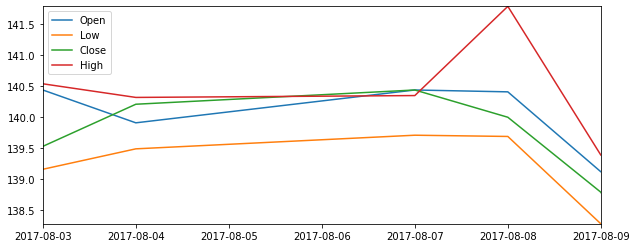

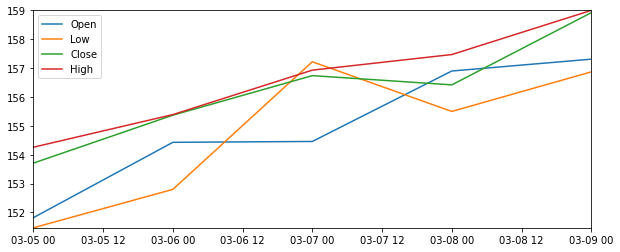

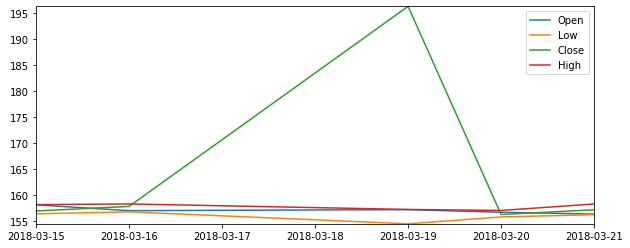

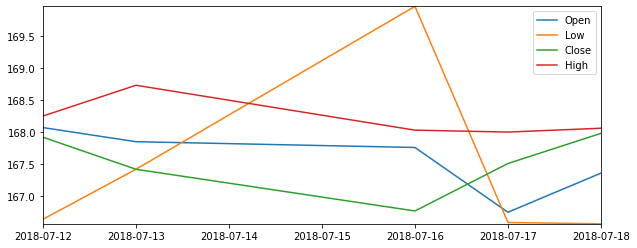

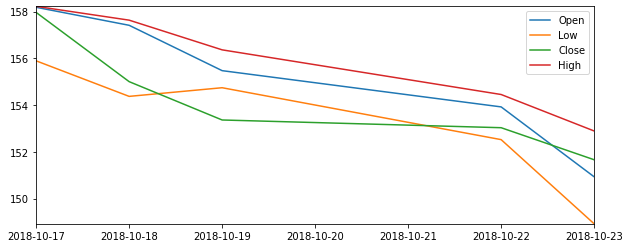

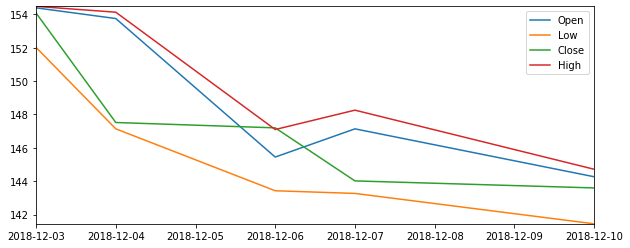

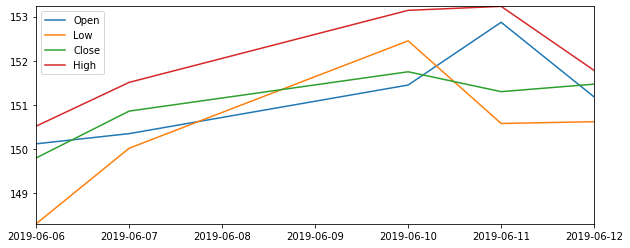

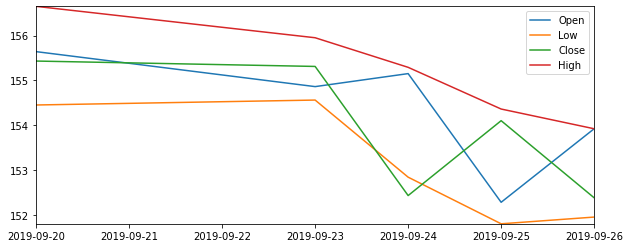

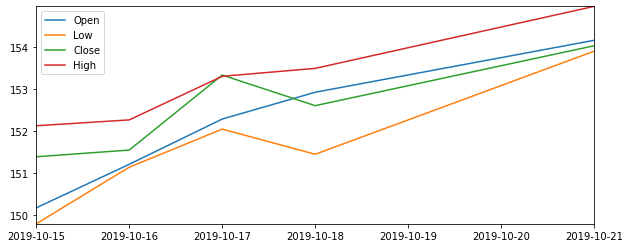

In [ ]:
# delete non trading day records
df = df[df['ErrorCode'].mod(10) != 1]
df.index = range(len(df))
# 'low' < 'open','close' < 'high'
def plot_date(i):
  fig, ax = plt.subplots(figsize = (10,4))
  ax.plot(df['Date'],df['Open'], label = 'Open')
  ax.plot(df['Date'],df['Low'], label = 'Low')
  ax.plot(df['Date'],df['Close'], label = 'Close')
  ax.plot(df['Date'],df['High'], label = 'High')
  ax.set_ylim(df.iloc[i-2:i+3,2:6].min().min(),df.iloc[i-2:i+3,2:6].max().max())
  ax.set_xlim([df.loc[i-2,'Date'], df.loc[i+2,'Date']])
  ax.legend()
for i in df[df['ErrorCode'].mod(100) == 20].index:
  plot_date(i)

For those days, I set `High` as the highest price, and `Low` as  the lowest price. 

An exception is on 2018-03-19 with ErrorCode 120. I think `High` and `Low` here are good and `Close` needs to be changed. 

In [ ]:
for i in df[df['ErrorCode'] == 20].index:
  if df.loc[i,'High'] < max(df.loc[i,['Open','Close']]):
    df.loc[i,'High'] = max(df.loc[i,['Open','Close']])
  if df.loc[i,'Low'] > min(df.loc[i,['Open','Close']]):
    df.loc[i,'Low'] = min(df.loc[i,['Open','Close']])
df.loc[df[df['ErrorCode'] == 120].index, 'Close'] = df.loc[df[df['ErrorCode'] == 120].index, 'High']

**modify the negative price**

In [ ]:
df[(df['ErrorCode']//10).mod(10).mod(2) == 1]

,Date,Signal,Open,High,Low,Close,Adj Close,ErrorCode,diff_close
727,2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,-152.277847,110,308.837845


In [ ]:
df.loc[df[(df['ErrorCode']//10).mod(10).mod(2) == 1].index, 'Adj Close'] = df.loc[df[(df['ErrorCode']//10).mod(10).mod(2) == 1].index, 'Adj Close']*(-1)

**abnormal pattern in 2017-09**

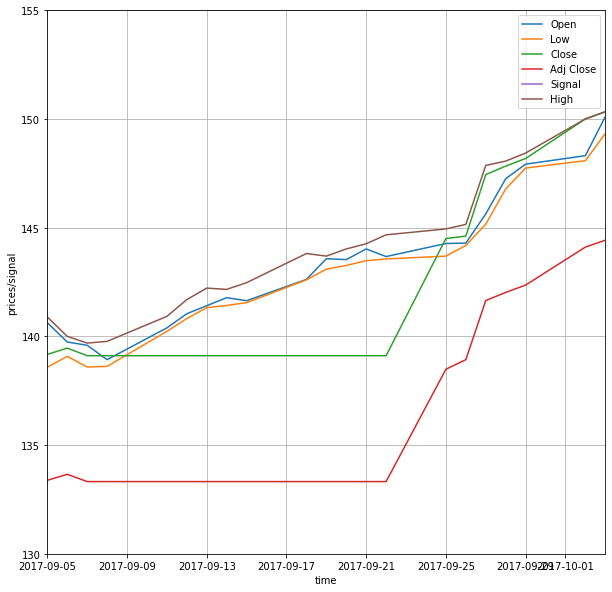

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(df['Date'],df['Open'], label = 'Open')
ax.plot(df['Date'],df['Low'], label = 'Low')
ax.plot(df['Date'],df['Close'], label = 'Close')
ax.plot(df['Date'],df['Adj Close'], label = 'Adj Close')
ax.plot(df['Date'],df['Signal'], label = 'Signal')
ax.plot(df['Date'],df['High'], label = 'High')
ax.set_xlabel('time')
ax.set_ylabel('prices/signal')
ax.set_xlim([df.loc[450,'Date'], df.loc[470,'Date']])
ax.set_ylim(130,155)
ax.grid(True)
ax.legend()

I set the `Close` the same as `Open`, and change `Adj Close` accordingly. 

In [ ]:
for i in df[df['ErrorCode'] == 40].index:
  df.loc[i, 'Adj Close'] += df.loc[i, 'Open'] - df.loc[i, 'Close']
  df.loc[i, 'Close'] = df.loc[i, 'Open']

**Adj Close**

Simple interpolation is used to replace the abnormal `Adj Close`

In [ ]:
for i in df[df['ErrorCode'] == 100].index:
  print(df.loc[i-1:i+1,['Close','Adj Close']])
for i in df[df['ErrorCode'] == 100].index:
  df.loc[i,'Adj Close'] = (df.loc[i-1,'Adj Close'] + df.loc[i+1,'Adj Close']) / 2

          Close   Adj Close
261  130.899994  124.042938
262  133.149994  166.175079
263  134.589996  127.539658
          Close   Adj Close
337  134.490005  128.339050
338  134.740005  158.577637
339  135.789993  129.579605


**Signal**

Outliers are repleced using moving average. Days with missing `Adj Signal` (0) are deleted. 

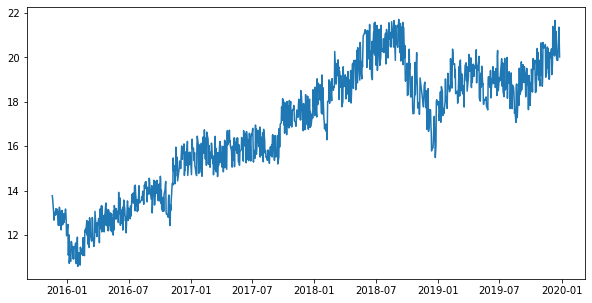

In [ ]:
df['Adj Signal'] = np.where(df['Signal'].diff(1) > 4,
         df['Signal'].shift(1).rolling(3,min_periods=1).mean(),
         df['Signal'])
df_adj = df[df['Signal'] != 0]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(df_adj['Date'],df_adj['Adj Signal'], label = 'Signal')

# 2. Signal’s Effectiveness or Lack

## Price or Price Change?

I want to know if it's a good prediction of price or price change.

Apparently, adjusted signal is highly correlated to the price with a high pearson r. The plot also shows that there is a lag between them.

In comparison between `Signal` with and without abnormal values( `Signal - Adj Close` vs `Adj Signal - Adj Close`), `Adj Signal - Adj Close` has a higher correlation. It means those abnormal values are errors, not market signals. 



**Signal - Adj Close**

In [ ]:
np.corrcoef(df_adj['Adj Close'], df_adj['Signal'])[0][1]

0.9377406543664563

**Adj Signal - Adj Close**

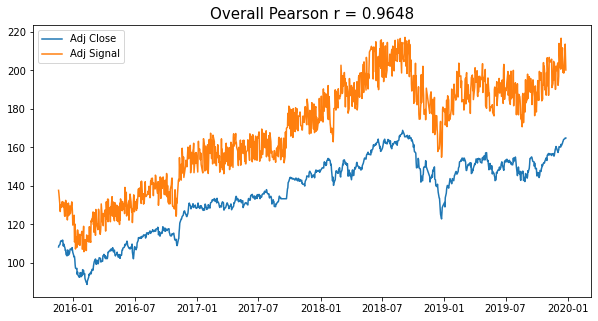

In [ ]:
r_price = np.corrcoef(df_adj['Adj Close'], df_adj['Adj Signal'])[0][1]

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(df_adj['Date'],df_adj['Adj Close'], label = 'Adj Close')
ax.plot(df_adj['Date'],df_adj['Adj Signal']*10, label = 'Adj Signal')
ax.set_title('Overall Pearson r = ' + str(round(r_price, 4)), fontsize = 15)
ax.legend()

Price change in 1/3/5/10/30/60/120 days are checked and no significant correlation is observed.

In [ ]:
index = []
cc = []
for i in [1, 3, 5, 10, 30, 60, 120]:
  index.append(i)
  cc.append(round(np.corrcoef(df_adj['Adj Signal'][i:],df_adj['Adj Close'].diff(i)[i:])[0][1], 4))
pd.DataFrame(list(zip(index, cc)), columns = ['day of return','corr-coef']).set_index('day of return')

,corr-coef
day of return,
1,0.0318
3,0.0564
5,0.0680
10,0.0902
30,0.1140
60,0.0254
120,-0.1199


## Time Series Analysis and Autocorrelation

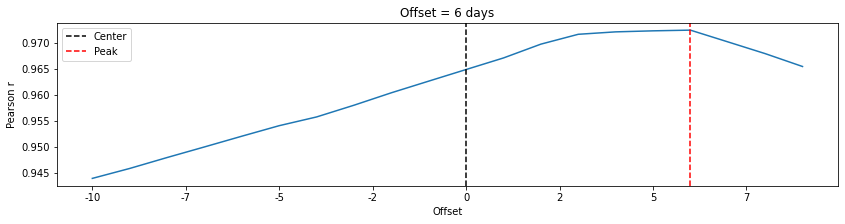

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

rs = [crosscorr(df_adj['Adj Close'],df_adj['Adj Signal'], lag) for lag in range(-10,10)]
offset = round(np.argmax(rs) - len(rs)/2)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak')
ax.set(title=f'Offset = {offset} days', xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-10) for item in ax.get_xticks()])
plt.legend()
plt.show()

This figure above depicts TLCC among selected time series for an offset from −10 to 10 trading days. When lag equals 6, the two series have the highest correlation coefficient. This might explain why `Signal` doesn't include values of last 6 days. 

ACF and PACF are used to check lags within `Adj Close`. The plot shows that it doesn't have a significant lag. 

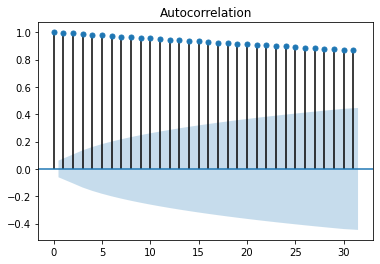

In [ ]:
plot_acf(df_adj['Adj Close'])
plt.show()

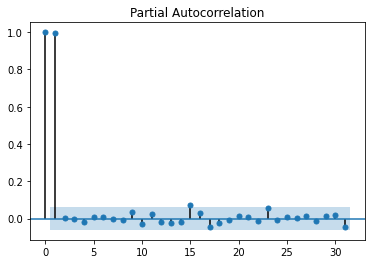

In [ ]:
plot_pacf(df_adj['Adj Close'])
plt.show()

# 3. Summary
Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

**Quality Issues Observed**: Several data quality issues are oberved and take up 3.4% of all records, which is acceptable. The sample dataset consists of non-trading days like weekends and national holidays, and misses 5 trading days. There are a lot glaringly wrong values in both price part and signal part. Even if errors are only a small fraction of sample, the variety of the errors is worrying. Considering they're all publicly available historical data, I doubt the believability of the firm's products. 

**Efficacy**: The Signal is a good prediction of adjusted closing prices with a 6-day lag. It has a Pearson r of 0.97. However, it doesn't help much with predicting price change or return. 

**Suggestions**: I suggest that we ask more information from the firm about the Signal, like how the data should be used and when can we get the data for each trading day. Also, I think we should ask more sample data to monitor the efficacy in recent months and check if data quality issues are well addressed. 

In [ ]:
%%shell
jupyter nbconvert --to html /content/Millenium.ipynb

[NbConvertApp] Converting notebook /content/Millenium.ipynb to html
[NbConvertApp] Writing 1067688 bytes to /content/Millenium.html
